In [883]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.utils import resample
import xgboost as xgb
import os

data_dir = ""
for dirname, _, filenames in os.walk('../../data/'):
    data_dir = dirname
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

../../data/tcdml1920-rec-click-pred--submission file (example).csv
../../data/tcdml1920-rec-click-pred--submission file.csv
../../data/tcdml1920-rec-click-pred--test.csv
../../data/tcdml1920-rec-click-pred--training.csv


In [169]:
raw_train_df = pd.read_csv(data_dir+"/tcdml1920-rec-click-pred--training.csv")
raw_test_df = pd.read_csv(data_dir+"/tcdml1920-rec-click-pred--test.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (4,5,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [917]:
def data_cleaning(train_df, test_df, split_method, cblog_split):
    
    time_cols = ['abstract_char_count', 'abstract_detected_language', 'query_word_count', 'query_detected_language', 'item_type', 'organization_id',            
            'app_lang', 'country_by_ip', 'hour_request_received', 'local_hour_of_request',
            'algorithm_class','recommendation_algorithm_id_used']    
    
   
    jabref_cols = ['query_char_count', 'app_lang', 'app_version', 'country_by_ip', 'timezone_by_ip', 
               'local_hour_of_request', 'algorithm_class', 'recommendation_algorithm_id_used']

    cbf_cols = ['cbf_parser']

    com_blog_cols = ['query_word_count', 'query_detected_language', 'abstract_char_count',
                     'organization_id', 'hour_request_received', 'item_type',
                     'country_by_ip', 'algorithm_class', 'recommendation_algorithm_id_used']
    
    id_col = ['recommendation_set_id']
    
    dep_cols = ['clicks', 'ctr', 'set_clicked']
    
    train_df = train_df[train_df['rec_processing_time']<40]
    train_df = train_df[train_df['clicks']<= train_df['number_of_recs_in_set']]
    
    train_df = train_df[~(train_df['app_version'].isna())]
    
    cleaned_data = {}
    
    for key, df in {'test':test_df, 'train':train_df}.items():
        print(key)
        df = df.replace("\\N", np.nan)
        cols_to_change = ['query_word_count', 'query_char_count', 'local_hour_of_request', 'recommendation_algorithm_id_used',
                     'abstract_char_count', 'abstract_word_count']
        df[cols_to_change] = df[cols_to_change].astype('float64')
        df['q_doc_id_provided'] = df['query_document_id'].apply(lambda x: 0 if pd.isnull(x) else 1)
        
        data_dict = {}
        if split_method=='app-cbf':
            
            if key=='test':
                com_blog_cols = com_blog_cols + id_col
                jabref_cols = jabref_cols + id_col
                time_cols = time_cols + id_col
            else:
                com_blog_cols = list(set(com_blog_cols + ['set_clicked']) - set(id_col))
                jabref_cols = list(set(jabref_cols + ['set_clicked']) - set(id_col))
                time_cols = list(set(time_cols + ['set_clicked']) - set(id_col))
                
            cblog_all = df[df['organization_id']!=1]
        
            if cblog_split=='viewed':
                if key=='train':
                    cblog_all = cblog_all[~(cblog_all['time_recs_viewed'].isna())][time_cols + cbf_cols]
                else:
                    pass
                data_dict['cblog_viewed'] = cblog_all[~(cblog_all['organization_id'].isna())][time_cols + cbf_cols]
                
            else:
                cblog_cbf = cblog_all[cblog_all['algorithm_class']=='content_based_filtering'][com_blog_cols + cbf_cols]
                #cblog_cbf = cblog_cbf[~(cblog_cbf['country_by_ip'].isna())]
                cblog_other = df[df['organization_id']!=1][com_blog_cols]
                cblog_other = cblog_other[cblog_other['algorithm_class']!='content_based_filtering']
#             cblog_other = cblog_other[~(cblog_other['country_by_ip'].isna())]
                data_dict['cblog_cbf'] = cblog_cbf
                data_dict['cblog_other'] = cblog_other
                
            
            
            dig_all = df[df['organization_id']==1]
            dig_cbf = dig_all[dig_all['algorithm_class']=='content_based_filtering'][jabref_cols+cbf_cols+ ['query_detected_language', 'q_doc_id_provided']]
            #dig_cbf = dig_cbf[~((dig_cbf['country_by_ip'].isna()) | (dig_cbf['app_lang'].isna()) | (dig_cbf['app_version'].isna()))]
            dig_other = df[df['organization_id']==1][jabref_cols]
            dig_other = dig_other[dig_other['algorithm_class']!='content_based_filtering']
            #dig_other = dig_other[~((dig_other['app_lang'].isna()) | (dig_other['app_version'].isna()))]

            data_dict['dig_cbf'] = dig_cbf
            data_dict['dig_other'] = dig_other
            cleaned_data[key] = data_dict
            
        elif split_method=='time_viewed':
            if key=='test':
                df = df[~(df['application_type'].isna())]
                df = df[time_cols + id_col]
                cleaned_data[key] = df
            else:
                df = df[(~df['time_recs_viewed'].isna()) | df['set_clicked']==1]
                df = df[time_cols + ['set_clicked']]
                cleaned_data[key] = df
        elif split_method=='algo':
            pass        
        
    return cleaned_data

In [918]:
cat_cols = ['item_type', 'organization_id', 'app_lang', 'app_version', 'country_by_ip', 'timezone_by_ip', 
            'algorithm_class','recommendation_algorithm_id_used', 'organization_id',
            'cbf_parser', 'query_detected_language', 'abstract_detected_language']

cleaned_data = data_cleaning(raw_train_df, raw_test_df, 'app-cbf', 'viewed')

test
train


In [881]:
raw_test_df[raw_test_df['organization_id']!=1]

,recommendation_set_id,user_id,session_id,query_identifier,query_word_count,query_char_count,query_detected_language,query_document_id,document_language_provided,year_published,number_of_authors,abstract_word_count,abstract_char_count,abstract_detected_language,first_author_id,num_pubs_by_first_author,organization_id,application_type,item_type,request_received,hour_request_received,response_delivered,rec_processing_time,app_version,app_lang,user_os,user_os_version,user_java_version,user_timezone,country_by_ip,timezone_by_ip,local_time_of_request,local_hour_of_request,number_of_recs_in_set,recommendation_algorithm_id_used,algorithm_class,cbf_parser,search_title,search_keywords,search_abstract,time_recs_recieved,time_recs_displayed,time_recs_viewed,clicks,ctr,set_clicked
3442,244453.0,\N,\N,Moog Effects pedal MF-108M Compatible Power Su...,12,73,en,\N,\N,\N,\N,\N,\N,\N,\N,\N,4.0,e-commerce,\N,19/06/2019 11:46,11.0,nA,nA,\N,en,\N,\N,\N,\N,DE,\N,\N,\N,nA,11,content_based_filtering,edismax_QP,yes,no,no,nA,nA,nA,nA,nA,NaN
3444,244483.0,\N,\N,Joyo Effects pedal Tremelo Compatible Power Su...,11,73,en,\N,\N,\N,\N,\N,\N,\N,\N,\N,4.0,e-commerce,\N,19/06/2019 11:59,11.0,nA,nA,\N,en,\N,\N,\N,\N,DE,\N,\N,\N,nA,2,content_based_filtering,edismax_QP,yes,yes,no,nA,nA,nA,nA,nA,NaN
3445,244620.0,\N,\N,JBL Bluetooth speaker Flip Compatible Power Su...,9,63,en,\N,\N,\N,\N,\N,\N,\N,\N,\N,4.0,e-commerce,\N,19/06/2019 12:56,12.0,nA,nA,\N,en,\N,\N,\N,\N,DE,\N,\N,\N,nA,2,content_based_filtering,edismax_QP,yes,yes,no,nA,nA,nA,nA,nA,NaN
3447,244705.0,\N,\N,Roland Guitar Amplifier CUBE-10GX Compatible P...,10,70,en,123983226,\N,\N,\N,114,752,en,\N,\N,4.0,e-commerce,\N,19/06/2019 13:33,13.0,nA,nA,\N,en,\N,\N,\N,\N,DE,\N,\N,\N,nA,10,content_based_filtering,mlt_QP,yes,yes,yes,nA,nA,nA,nA,nA,NaN
3450,244855.0,\N,\N,Clementoni Learning tablet Clempad 5.0 HD Clem...,13,104,en,\N,\N,\N,\N,\N,\N,\N,\N,\N,4.0,e-commerce,\N,19/06/2019 14:53,14.0,nA,nA,\N,en,\N,\N,\N,\N,DE,\N,\N,\N,nA,12,content_based_filtering,edismax_QP,yes,yes,yes,nA,nA,nA,nA,nA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [910]:
cleaned_data['test']['dig_cbf'].shape

(3797, 12)

In [914]:
for key, dataset in cleaned_data['train'].items():
    print('\nDataset: ', key)
    for col in dataset.columns:
        if np.nan in dataset[col].value_counts(dropna=False).index:
            print('Col: ', col)
            num = dataset[col].value_counts(dropna=False).loc[np.nan]
            percent = dataset[col].value_counts(dropna=False, normalize= True).loc[np.nan]
            print('Num: ', num, ' Percent: ', percent)


Dataset:  cblog_viewed

Dataset:  dig_cbf

Dataset:  dig_other


In [912]:
for col in cleaned_data['train'].columns:
        if np.nan in cleaned_data['train'][col].value_counts(dropna=False).index:
            print('Col: ', col)
            num = cleaned_data['train'][col].value_counts(dropna=False).loc[np.nan]
            percent = cleaned_data['train'][col].value_counts(dropna=False, normalize= True).loc[np.nan]
            print('Num: ', num, ' Percent: ', percent)

AttributeError: 'dict' object has no attribute 'columns'

In [495]:
def group_cols(df, group, grouped):
    group_df = df.groupby(group).agg({grouped: lambda x: x.value_counts().index[0] if len(x.value_counts().index) > 0 else 'unknown'}).rename(columns={'<lambda>': grouped}).reset_index().set_index(group)
    return group_df

In [443]:
cleaned_data['test']['query_detected_language'].value_counts(dropna=False)

0.304444    7895
0.853609     600
0.725561     114
0.676034      83
0.612246      75
0.664665      72
0.442123      38
0.451841      38
0.479512      32
0.495718      29
0.471049      24
0.390149      23
0.408536      19
0.466713      16
0.403110      14
0.413865      14
0.401241      14
0.419098      12
0.429290      12
0.376783      10
0.379065       5
0.391953       3
NaN            2
0.362147       1
Name: query_detected_language, dtype: int64

In [841]:
for dataset, data in cleaned_data.items():
    
    group_df = group_cols(cleaned_data[dataset], ['organization_id', 'algorithm_class'], 'recommendation_algorithm_id_used')
    cleaned_data[dataset]['recommendation_algorithm_id_used'] = cleaned_data[dataset].apply(lambda x: group_df.loc[(x['organization_id'], x['algorithm_class'])][0] if pd.isnull(x['recommendation_algorithm_id_used']) else x['recommendation_algorithm_id_used'], axis=1)
    
    group_df = group_cols(cleaned_data[dataset], ['organization_id'], 'item_type')
    cleaned_data[dataset]['item_type'] = cleaned_data[dataset].apply(lambda x: group_df.loc[x['organization_id']][0] if pd.isnull(x['item_type']) else x['item_type'], axis=1)
    
    group_df = group_cols(cleaned_data[dataset], ['organization_id', 'hour_request_received'], 'country_by_ip')
    cleaned_data[dataset]['country_by_ip'] = cleaned_data[dataset].apply(lambda x: group_df.loc[(x['organization_id'], x['hour_request_received'])][0] if pd.isnull(x['country_by_ip']) else x['country_by_ip'], axis=1)
    
    #
    missing_values = {'query_word_count': data['query_word_count'].median(), 'query_detected_language': data['query_detected_language'].mode()[0],
                     'app_lang': data['app_lang'].mode()[0], 'local_hour_of_request': data['local_hour_of_request'].median(),
                     'abstract_char_count': data['abstract_char_count'].median(), 'abstract_detected_language': data['abstract_detected_language'].mode()[0]}
    
    cleaned_data[dataset] = cleaned_data[dataset].fillna(value=missing_values)

In [919]:
for dataset, data in cleaned_data.items():
    for key, df in data.items():
        
        if key=='cblog_viewed':
            group_df = group_cols(cleaned_data[dataset][key], ['organization_id'], 'item_type')
            cleaned_data[dataset][key]['item_type'] = cleaned_data[dataset][key].apply(lambda x: group_df.loc[x['organization_id']][0] if pd.isnull(x['item_type']) else x['item_type'], axis=1)
    
            group_df = group_cols(cleaned_data[dataset][key], ['organization_id', 'hour_request_received'], 'country_by_ip')
            cleaned_data[dataset][key]['country_by_ip'] = cleaned_data[dataset][key].apply(lambda x: group_df.loc[(x['organization_id'], x['hour_request_received'])][0] if pd.isnull(x['country_by_ip']) else x['country_by_ip'], axis=1)
            
            group_df = group_cols(cleaned_data[dataset][key], ['organization_id'], 'cbf_parser')
            cleaned_data[dataset][key]['cbf_parser'] = cleaned_data[dataset][key].apply(lambda x: group_df.loc[x['organization_id']][0] if pd.isnull(x['cbf_parser']) else x['cbf_parser'], axis=1)
            
            missing_values = {'query_detected_language': df['query_detected_language'].mode()[0], 
#                               'abstract_char_count': df['abstract_char_count'].median(), 
                              'query_word_count': df['query_word_count'].median(),
                             'app_lang': df['app_lang'].mode()[0], 'local_hour_of_request': df['local_hour_of_request'].median(),
                     'abstract_char_count': df['abstract_char_count'].median(), 'abstract_detected_language': df['abstract_detected_language'].mode()[0]}
            
            cleaned_data[dataset][key] = df.fillna(value=missing_values)
                    
        elif key=='dig_cbf':
            
            missing_values = {'app_lang': df['app_lang'].mode()[0], 'app_version': df['app_version'].mode()[0], 'country_by_ip': 'missing', 'timezone_by_ip': 'missing', 'query_detected_language': df['query_detected_language'].mode()[0], 
                         'local_hour_of_request': df['local_hour_of_request'].median()}
            cleaned_data[dataset][key]= df.fillna(value=missing_values)
            
        else:
                        
            missing_values = {'app_lang': df['app_lang'].mode()[0], 'app_version': df['app_version'].mode()[0], 'country_by_ip': 'missing', 'timezone_by_ip': 'missing', 
                'local_hour_of_request': df['local_hour_of_request'].median(), 'recommendation_algorithm_id_used': 33}
            cleaned_data[dataset][key]= df.fillna(value=missing_values)
            

In [510]:
for dataset, data in cleaned_data.items():
    for key, df in data.items():
        
        if key=='cblog_cbf':
            missing_values = {'query_detected_language': df['query_detected_language'].mode()[0], 
                              'country_by_ip': 'missing', 'abstract_char_count': df['abstract_char_count'].median(), 
                            'item_type': 'missing', 'query_word_count': df['query_word_count'].median()}
            cleaned_data[dataset][key] = df.fillna(value=missing_values)
            
        elif key=='cblog_other':    
            missing_values = {'query_detected_language': df['query_detected_language'].mode()[0],
                              'abstract_char_count': df['abstract_char_count'].median(), 'query_word_count': df['query_word_count'].median(),
                         'item_type': 'missing', 'country_by_ip': 'missing'}
            cleaned_data[dataset][key] = df.fillna(value=missing_values)
           
        elif key=='dig_cbf':
            missing_values = {'app_lang': df['app_lang'].mode()[0], 'country_by_ip': 'missing', 'timezone_by_ip': 'missing', 'query_detected_language': df['query_detected_language'].mode()[0], 
                         'local_hour_of_request': df['local_hour_of_request'].median()}
            cleaned_data[dataset][key]= df.fillna(value=missing_values)
            
        else:
            missing_values = {'app_lang': df['app_lang'].mode()[0], 'country_by_ip': 'missing', 'timezone_by_ip': 'missing', 
                'local_hour_of_request': df['local_hour_of_request'].median(), 'recommendation_algorithm_id_used': 33}
            cleaned_data[dataset][key]= df.fillna(value=missing_values)
            
       


In [782]:
def calc_smooth_mean(df, df_train, by, on, m):
    # Compute the global mean
    mean = df_train[on].mean()

    # Compute the number of values and the mean of each group
    agg = df_train.groupby(by)[on].agg(['count', 'mean'])
    
    counts = agg['count']
    means = agg['mean']
    
    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)
#     print(smooth.index)
    # Replace each value by the according smoothed mean
    return df[by].apply(lambda x: smooth.loc[str(x)] if str(x) in smooth.index else 0)

In [915]:
def preprocess_data(cleaned_data, cat_cols, target, scaling_method):
    
    processed_data = {}
    
#     for key, df in cleaned_data['train']:
#         train_df = cleaned_data['train'][key]
#         test_df = cleaned_data['test'][key]
        
        
    for dataset, data in cleaned_data.items():
        processed_data[dataset] =  {}
#         print('Type: ', dataset, ' Shape: ', data.shape)
        
#         data = data.drop(columns=['country_by_ip', 'item_type', 'organization_id'])
#         df_cat_cols = list(set(cat_cols).intersection(set(data.columns)))
#         if dataset=='train':
#             df_num_cols = list(set(data.columns) - set(df_cat_cols) -set([target]))
#         else:
#             df_num_cols = list(set(data.columns) - set(df_cat_cols) - set(['recommendation_set_id']))
        
#         if scaling_method=='standard':
#             scaler = StandardScaler()
#             data[df_num_cols] = scaler.fit_transform(data[df_num_cols])
                
#         else:
#             scaler = MinMaxScaler()
#             data[df_num_cols] = scaler.fit_transform(data[df_num_cols])
        
#         for col in df_cat_cols:
            
#             data[col] = calc_smooth_mean(data, cleaned_data['train'], col, 'set_clicked', 100)
        
#         if dataset=='train': 
#             X_train, X_valid, y_train, y_valid = train_test_split(data[df_num_cols+df_cat_cols].values, data[target].values, test_size=0.2)
#             processed_data[dataset] = {'X': data[df_num_cols+df_cat_cols].values, 'y': data[target].values,
#                                             'X_train': X_train, 'X_valid': X_valid, 'y_train': y_train, 'y_valid': y_valid}
#         else:
#             processed_data[dataset] = {'data': data[df_num_cols + df_cat_cols], 'id': data['recommendation_set_id']}
            
        for key, df in data.items():
            
            
            print('Type: ', dataset, ' Dataset: ', key, ' Shape: ', df.shape)
            df_cat_cols = list(set(cat_cols).intersection(set(df.columns)))
            
            if dataset=='train':
                df_num_cols = list(set(df.columns) - set(df_cat_cols) -set([target]))
            else:
                df_num_cols = list(set(df.columns) - set(df_cat_cols) - set(['recommendation_set_id']))
                
            if scaling_method=='standard':
                scaler = StandardScaler()
                df[df_num_cols] = scaler.fit_transform(df[df_num_cols])
                
            else:
                scaler = MinMaxScaler()
                df[df_num_cols] = scaler.fit_transform(df[df_num_cols])
            
            for col in df_cat_cols:
#                 df_x = cleaned_data['train'][key][[col, 'set_clicked']].astype({col: str}).groupby(by=[col]).mean()           
#                 df[col] = df[col].apply(lambda x: df_x.loc[str(x)][0] if str(x) in df_x.index else 0) 
                df[col] = calc_smooth_mean(df, cleaned_data['train'][key], col, 'set_clicked', 150)
            
        
            if dataset=='train': 
                X_train, X_valid, y_train, y_valid = train_test_split(df[df_num_cols+df_cat_cols].values, df[target].values, test_size=0.3)
                processed_data[dataset][key] = {'X': df[df_num_cols+df_cat_cols].values, 'y': df[target].values,
                                                'X_train': X_train, 'X_valid': X_valid, 'y_train': y_train, 'y_valid': y_valid}
            else:
                processed_data[dataset][key] = {'data': df[df_num_cols + df_cat_cols].values, 'id': df['recommendation_set_id'].values}
                
    return processed_data

In [920]:
processed_data = preprocess_data(cleaned_data, cat_cols, 'set_clicked', 'standard')

Type:  test  Dataset:  cblog_viewed  Shape:  (3969, 14)
Type:  test  Dataset:  dig_cbf  Shape:  (3797, 12)
Type:  test  Dataset:  dig_other  Shape:  (1379, 9)
Type:  train  Dataset:  cblog_viewed  Shape:  (13073, 14)
Type:  train  Dataset:  dig_cbf  Shape:  (193352, 12)
Type:  train  Dataset:  dig_other  Shape:  (76710, 9)


In [560]:
processed_data['test']['dig_other']['data'].columns

Index(['local_hour_of_request', 'query_char_count',
       'recommendation_algorithm_id_used', 'app_lang', 'algorithm_class',
       'country_by_ip', 'app_version', 'timezone_by_ip'],
      dtype='object')

In [543]:
results = {}
for key, data in processed_data['train'].items():
#     logit = LogisticRegression()
    
    xgb_cl = xgb.XGBClassifier()
    sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2)
    #X_train, X_valid, y_train, y_valid = train_test_split(data['X'], data['y'], test_size=0.2)
    for train_index, test_index in sss.split(data['X'], data['y']):
        X_train, X_valid = data['X'][train_index], data['X'][test_index]
        y_train, y_valid = data['y'][train_index], data['y'][test_index]
    
    xgb_cl.fit(X_train, y_train)
    y_pred= xgb_cl.predict(X_valid)
    
    print(len(y_valid), len(y_pred))
    f1 = f1_score(y_valid, y_pred, average='micro')
    precision = precision_score(y_valid, y_pred, average='micro')
    recall = recall_score(y_valid, y_pred, average='micro')
    cm = confusion_matrix(y_valid, y_pred)
    results[key] = {'F1':f1, ' Precision': precision, 'Recall': recall, 'CM': cm}

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


16325 16325


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


6782 6782


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


38658 38658
15335 15335


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [541]:
results

{'cblog_cbf': {' Precision': 0.9890964777947933, 'CM': array([[16147,     0],
         [  178,     0]], dtype=int64), 'F1': 0.9890964777947933, 'Recall': 0.9890964777947933},
 'cblog_other': {' Precision': 0.9904158065467413, 'CM': array([[6717,    0],
         [  65,    0]], dtype=int64), 'F1': 0.9904158065467413, 'Recall': 0.9904158065467413},
 'dig_cbf': {' Precision': 0.9785038025764395, 'CM': array([[37827,     0],
         [  831,     0]], dtype=int64), 'F1': 0.9785038025764394, 'Recall': 0.9785038025764395},
 'dig_other': {' Precision': 0.9822627975220085, 'CM': array([[15063,     0],
         [  272,     0]], dtype=int64), 'F1': 0.9822627975220085, 'Recall': 0.9822627975220085}}

In [844]:
model = RandomForestClassifier(n_estimators=100)
results = []
model.fit(processed_data['train']['X_train'], processed_data['train']['y_train'])
y_pred = model.predict(processed_data['train']['X_valid'])

f1 = f1_score(processed_data['train']['y_valid'], y_pred)
precision = precision_score(processed_data['train']['y_valid'], y_pred)
recall = recall_score(processed_data['train']['y_valid'], y_pred)
cm = confusion_matrix(processed_data['train']['y_valid'], y_pred)
results = {'F1':f1, ' Precision': precision, 'Recall': recall, 'CM': cm}

In [845]:

print(results)

{'F1': 0.8328244274809161, ' Precision': 0.8714057507987221, 'Recall': 0.797514619883041, 'CM': array([[2324,  161],
       [ 277, 1091]], dtype=int64)}


In [853]:
model = SVC()
model.fit(processed_data['train']['X'], processed_data['train']['y'])
y_pred = model.predict(processed_data['test']['data'])
result = np.hstack((processed_data['test']['id'].values.reshape(-1, 1), y_pred.reshape(-1, 1)))
result = pd.DataFrame(data = result, columns=['recommendation_set_id', 'set_clicked'])
result['recommendation_set_id'] = result['recommendation_set_id'].astype(int)
result['set_clicked'] = result['set_clicked'].astype(int)
result.sort_values(by='recommendation_set_id', inplace=True)
# result.to_csv('Submission-file.csv', encoding='utf-8', index=Fals

In [854]:
result['set_clicked'].sum()

4702

In [848]:
model.feature_importances_

array([0.08463895, 0.20830755, 0.49645604, 0.10198691, 0.        ,
       0.03510138, 0.02742459, 0.00498334, 0.04110125])

In [ ]:
# model = RandomForestClassifier(n_estimators=100)
model = xgb.XGBClassifier()
model.fit(processed_data['train']['X'], processed_data['train']['y'])
y_pred = model.predict(processed_data['test']['data'])

result = np.hstack((processed_data['test']['id'].values.reshape(-1, 1), y_pred.reshape(-1, 1)))                   
result = pd.DataFrame(data = result, columns=['recommendation_set_id', 'set_clicked'])
result['recommendation_set_id'] = result['recommendation_set_id'].astype(int)
result.sort_values(by='recommendation_set_id', inplace=True)
result.to_csv('tcdml1920-rec-click-pred--submission file.csv', encoding='utf-8', index=False)

In [784]:
test_preds = {}
feature_imp = []
from xgboost import plot_importance
#logit = LogisticRegression()
model = RandomForestClassifier(n_estimators=100)
# model = xgb.XGBClassifier(n_estimators=100, subsample=0.8)
for key, data in processed_data['test'].items():
    X = processed_data['train'][key]['X']
    y = processed_data['train'][key]['y']
    
    df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
    df_0 = df[df.iloc[:, -1]==0]
    df_1 = df[df.iloc[:, -1]==1]
    
    
    df_1_new = resample(df_1, replace=True, n_samples = round(df_1.shape[0]*2))
    df_0_new = resample(df_0, replace=True, n_samples=df_1.shape[0]*12)
    
    df = pd.concat([df_0, df_1])
    X = df.iloc[:, :-1].values
    y = df.iloc[: , -1].values
    
    model.fit(X, y)
    y_pred= model.predict(data['data'])
    test_preds[key] = y_pred
#     feature_imp.append(plot_importance(model))



In [690]:
model.feature_importances_

array([0.21667525, 0.49781791, 0.02987827, 0.0241417 , 0.01019352,
       0.12921904, 0.02512556, 0.06694875])

In [655]:
processed_data['test']['dig_other']['data'].isnull().sum()

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'

In [669]:
for key, data in processed_data['train'].items():
    print('Data: ', key, ' Clicked: ', data['y'].sum()/len(data['y']))


Data:  cblog_viewed  Clicked:  0.04650807006807925
Data:  dig_cbf  Clicked:  0.021509992138690058
Data:  dig_other  Clicked:  0.017794290183809153


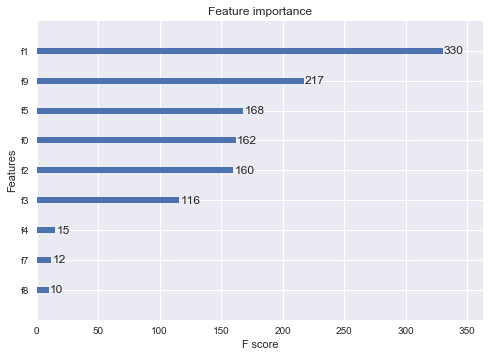

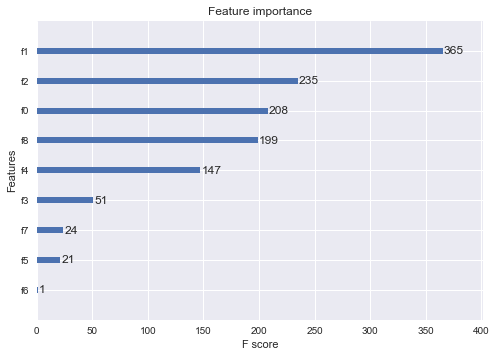

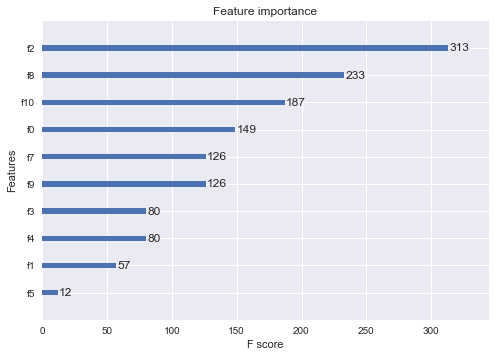

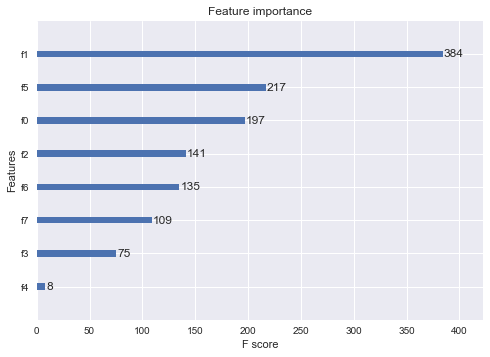

In [579]:
feature_imp[0]
plt.show()

In [785]:
result = np.vstack((np.hstack((processed_data['test']['cblog_viewed']['id'].reshape(-1, 1), test_preds['cblog_viewed'].reshape(-1, 1))),
                   np.hstack((processed_data['test']['dig_cbf']['id'].reshape(-1, 1), test_preds['dig_cbf'].reshape(-1, 1))),
                   np.hstack((processed_data['test']['dig_other']['id'].reshape(-1, 1), test_preds['dig_other'].reshape(-1, 1)))))
    
result = pd.DataFrame(data = result, columns=['recommendation_set_id', 'set_clicked'])
result['recommendation_set_id'] = result['recommendation_set_id'].astype(int)
result['set_clicked'] = result['set_clicked'].astype(int)
result.sort_values(by='recommendation_set_id', inplace=True)
result.to_csv('Submission-file.csv', encoding='utf-8', index=False)

In [ ]:
result = np.vstack((np.hstack((processed_data['test']['cblog_cbf']['id'].values.reshape(-1, 1), test_preds['cblog_cbf'].reshape(-1, 1))),
                   np.hstack((processed_data['test']['cblog_other']['id'].values.reshape(-1, 1), test_preds['cblog_other'].reshape(-1, 1))),
                   np.hstack((processed_data['test']['dig_cbf']['id'].values.reshape(-1, 1), test_preds['dig_cbf'].reshape(-1, 1))),
                   np.hstack((processed_data['test']['dig_other']['id'].values.reshape(-1, 1), test_preds['dig_other'].reshape(-1, 1)))))
    
result = pd.DataFrame(data = result, columns=['recommendation_set_id', 'set_clicked'])
result['recommendation_set_id'] = result['recommendation_set_id'].astype(int)
result['set_clicked'] = result['set_clicked'].astype(int)
result.sort_values(by='recommendation_set_id', inplace=True)
result.to_csv('Submission-file.csv', encoding='utf-8', index=False)

In [786]:
result['set_clicked'].sum()

57

In [930]:
def fit_model(method, model, params, processed_data):
# Function for fitting regression models to the data. 

#   This function fits Linear Regression, Rudge Regression, Random Forest Regression and XGBoost regression models according
#   to specification. It also performs normal validation or K-Fold Cross validation if needed, otherwise fits the model on 
#   the whole dataset.


#       input: method (String)- 'kfold' for K-Fold Cross Validation, 'validation' for normal validation,
#                                'testing' for fitting model on whole training data.
#              model (String)- The model to apply: 'linear' (linear regression), 'ridge' (ridge regression), 
#                              'randomforest' (Random Forest regression), 'xgb' (XGBoost regression)                              
#              params (python dict) - parameters for the model
#              X, y  (np.array): Full training data and labels
#              X_train, y_train (np.array): Training data and label after validation split
#              X_valid, y_valid - Validation data after validation split
#              X_test - Whole testing data

#       returns: y_pred (np.array) - Predictions if method = 'testing'
#                otherwise prints rmse score for validation and mean and standard deviation of rmse scores for K-Fold

    if model=='logistic':
        classifier = LogisticRegression()
    elif model=='svc':
        classifier = SVC()
        
    elif model=='randomforest':
        if params is not None:
            classifier = RandomForestClassifier(n_estimators=params['n_estimators'], max_features='auto')
            
        else:
            classifier = RandomForestClassifier(n_estimators=100)                                              
                                              
    elif model=='xgb':
        if params is not None:
            classifier = xg_reg = xgb.XGBClassifier(objective ='binary:logistic', learning_rate = params['learning_rate'], 
                                            max_depth = params['max_depth'], n_estimators=params['n_estimators'],
                                            min_child_weight=params['min_child_weight'], 
                                            colsample_bytree=params['colsample_bytree'], subsample=params['subsample'], 
                                            gamma=params['gamma'], alpha=params['alpha'], tree_method = 'gpu_hist')
        else:
            classifier = xg_reg = xgb.XGBClassifier(n_estimators=100)
    elif model=="gauss":
        classifier = GaussianProcessClassifier()
    
    kfold_scores = {}
    if method=='kfold':
        kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        rmse_scores = []
        scores = {'f1': [], 'precision': [], 'recall': []}
        
        for key, data in processed_data['train'].items():
            for i, (train_index, test_index) in enumerate(kfold.split(X, y)):
                X_train, y_train, X_valid, y_valid = X[train_index], y[train_index], X[test_index], y[test_index]
        
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_valid)
            
#             f1_scores.append(sqrt(mean_squared_error(y_valid, y_pred)))
                scores['f1'].append(f1_score(y_valid, y_pred))
                scores['precision'].append(precision_score(y_valid, y_pred))
                scores['recall'].append(recall_score(y_valid, y_pred))
                cm = confusion_matrix(y_valid, y_pred)                  
            
#                 print("Dataset: ", key, "\nSplit: ", i, " F1 Score: ", f1, " Precision: ", precision, " Recall :", recall)
            
            kfold_scores[key] = scores
        
#             for key in scores.keys():
#                 print("Score: ", key, "\nMean : ", np.mean(scores[key]), " Std: ", np.std(scores[key]))  
            
            
        return kfold_scores
            
        
            
    elif method=='validation':
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_valid)
        print('RMSE Score: ', sqrt(mean_squared_error(y_valid, y_pred)))  
    
    elif method=='testing':
        classifier.fit(X, y)
        y_pred = regressor.predict(X_test)
        return y_pred

In [ ]:
data = {}
data['f1_mean'] = []
data['f1_std'] = []
data['precision_mean'] = []
data['precision_std'] = []
data['recall_mean'] = []
data['recall_std'] = []

for model in ["logistic", "svc", "randomforest", "xgb", "gauss"]:
    kfold_scores = fit_model("kfold", model, None, processed_data)
    for key, scores in kfold_scores.items():
        data['f1_mean'].append(np.mean(scores['f1']))
        data['precision_mean'].append(np.mean(scores['precision']))
        data['recall_mean'].append(np.mean(scores['recall']))
        data['f1_std'].append(np.std(scores['f1']))
        data['precision_std'].append(np.std(scores['precision']))
        data['recall_std'].append(np.std(scores['recall']))

arrays = [list(processed_data['train'].keys()), ["logistic", "svc", "randomforest", "xgb", "gauss"]]
index = pd.MultiIndex.from_product(arrays, names=['first', 'second'])

kfold_results = pd.DataFrame(data = data, index = index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packag

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
 

MultiIndex([('data1',     'logistic'),
            ('data1',          'svc'),
            ('data1', 'randomforest'),
            ('data1',          'xgb'),
            ('data1',        'gauss'),
            ('data2',     'logistic'),
            ('data2',          'svc'),
            ('data2', 'randomforest'),
            ('data2',          'xgb'),
            ('data2',        'gauss'),
            ('data3',     'logistic'),
            ('data3',          'svc'),
            ('data3', 'randomforest'),
            ('data3',          'xgb'),
            ('data3',        'gauss')],
           names=['first', 'second'])